<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/Autoencoder_YRBSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoders and Data Quality for Tabular Data**

In [1]:
!git clone https://github.com/ipeirotis/autoencoders_census.git
%cd autoencoders_census

Cloning into 'autoencoders_census'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 62 (delta 22), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (62/62), 3.22 MiB | 2.50 MiB/s, done.
/content/autoencoders_census


In [2]:
# This code imports the DataTransformer object from
# the notebook pandas2vector.ipynb
!pip install -q import_ipynb
import import_ipynb
from pandas2vector import DataTransformer
from data_loader import DataLoader


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.1 MB/s eta 0:00:00
importing Jupyter notebook from pandas2vector.ipynb


....
----------------------------------------------------------------------
Ran 4 tests in 0.083s

OK


importing Jupyter notebook from data_loader.ipynb


# Data Source

The used data stems from the Youth Risk Behavior Surveillance System by CDC (Centers for Disease Control and Prevention). It includes data on a set of surveys that track behaviors that can lead to poor health in students grades 9 through 12. [Here](https://www.cdc.gov/healthyyouth/data/yrbs/data.htm) is the link to the dataset.

Note: The dataset is updated every two years. We use the 2017 version of the national high school YRBS dataset.

## Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from pandas.api.types import is_numeric_dtype

In [5]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from numpy.random import uniform
from numpy.random import seed


In [6]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K
from keras import Model



In [7]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load Original Dataset

In [8]:
# Data Source
data_loader = DataLoader()
original_df = data_loader.load_original_data()
project_data, variable_types = data_loader.prepare_original_dataset(original_df)

# Data Transformation
data_transformer = DataTransformer(variable_types)
project_data_missing = data_transformer.add_missing_indicators(project_data)
transformed_df = data_transformer.transform_dataframe(project_data_missing)


In [9]:
original_df

,weight,age,sex,grade,race4,race7,stheight,stweight,bmi,bmipct,...,qnwenthungry,qnmusclestrength,qnsunscreenuse,qnindoortanning,qnsunburn,qnconcentrating,qncurrentasthma,qnwheresleep,qnspeakenglish,qntransgender
0,2.4095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,2.0,1.0,1.0,NaN,NaN,1.0,NaN
1,1.6614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,2.0,2.0,1.0,NaN,NaN,1.0,NaN
2,0.7049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,2.0,2.0,2.0,NaN,NaN,1.0,NaN
3,0.7966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,2.0,1.0,2.0,NaN,NaN,1.0,NaN
4,1.9776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14760,0.1285,18 years old or older,Female,NaN,Hispanic/Latino,Hispanic/Latino,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14761,0.1854,18 years old or older,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
14762,0.1464,18 years old or older,Female,NaN,Hispanic/Latino,Hispanic/Latino,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14763,0.4531,18 years old or older,Female,12th,White,White,1.73,54.43,18.1864,8.9,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
project_data.shape

(14765, 110)

In [11]:
transformed_df

,weight,stheight,stweight,bmi,bmipct,missing_weight,missing_age,missing_sex,missing_grade,missing_Hispanic_or_Latino,...,indoor_tanning_20 to 39 times,indoor_tanning_3 to 9 times,indoor_tanning_40 or more times,indoor_tanning_nan,difficulty_concentrating_No,difficulty_concentrating_Yes,difficulty_concentrating_nan,qcurrentasthma_nan,qwheresleep_nan,qnbikehelmet_nan
0,0.508875,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
1,0.347927,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,0.142144,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
3,0.161873,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
4,0.415955,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14760,0.018136,NaN,NaN,NaN,NaN,0,0,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
14761,0.030378,NaN,NaN,NaN,NaN,0,0,0,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
14762,0.021987,NaN,NaN,NaN,NaN,0,0,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
14763,0.087971,0.577465,0.188926,0.082226,0.089027,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


# Autoencoder training

## Architecture setup

In [12]:
latent_dimension = 1
batch_size = 20

hidden_nodes = 16

# The dimensionality of the dataframe is (nrows x dim).
# We keep the dim as the size of the input
input_dim = transformed_df.shape[1]

input_encoder = Input(shape=(input_dim,), name="Input_Encoder")

batch_normalize1 = BatchNormalization()(input_encoder)

hidden_layer = Dense(hidden_nodes, activation="relu", name="Hidden_Encoding")(
    batch_normalize1
)
batch_normalize2 = BatchNormalization()(hidden_layer)

z = Dense(latent_dimension, name="Mean")(batch_normalize2)

Define and create the encoder model.

In [13]:
encoder = Model(input_encoder, z, name="Encoder")

Define the decoder part of the autoencoder model. It's responsible for reconstructing the original input data from the compressed representation.

In [14]:
input_decoder = Input(shape=(latent_dimension,), name="Input_Decoder")
batch_normalize1 = BatchNormalization()(input_decoder)

decoder_hidden_layer = Dense(hidden_nodes, activation="relu", name="Hidden_Decoding")(
    batch_normalize1
)
batch_normalize2 = BatchNormalization()(decoder_hidden_layer)

decoded = Dense(input_dim, activation="linear", name="Decoded")(batch_normalize2)

In [15]:
decoder = Model(input_decoder, decoded, name="Decoder")

Combine the encoder and decoder models to create the complete autoencoder architecture.

In [16]:
encoder_decoder = decoder(encoder(input_encoder))

ae = Model(input_encoder, encoder_decoder)

ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Encoder (InputLayer)  [(None, 746)]             0         
                                                                 
 Encoder (Functional)        (None, 1)                 15017     
                                                                 
 Decoder (Functional)        (None, 746)               12782     
                                                                 
Total params: 27,799
Trainable params: 26,241
Non-trainable params: 1,558
_________________________________________________________________


## Train the Model

The training of an autoencoder model while effectively handling missing data with mask variables.

In [17]:
def masked_mse(y_true, y_pred):
    mask = tf.where(tf.math.is_nan(y_true), 0.0, 1.0)
    return tf.reduce_mean(tf.square(y_true - y_pred) * mask)

ae.compile(loss=masked_mse, optimizer="adam", weighted_metrics=[])

# Replace null values in the dataframe with zeros
transformed_df = transformed_df.fillna(0.0)

mask = np.where(transformed_df.isnull(), 0.0, 1.0)
mask = np.expand_dims(mask, axis=-1)

# Initialize lists to track losses
train_loss = []
val_loss = []

class LossTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss.append(logs.get('loss'))
        val_loss.append(logs.get('val_loss'))

loss_tracker = LossTracker()

history = ae.fit(
    transformed_df, transformed_df, sample_weight=mask, shuffle=True, epochs=10, batch_size=20,
    validation_split=0.2, verbose=0, callbacks=[loss_tracker]
)

## Examine Training Output Statistics

Visualize the training and validation loss values over epochs.

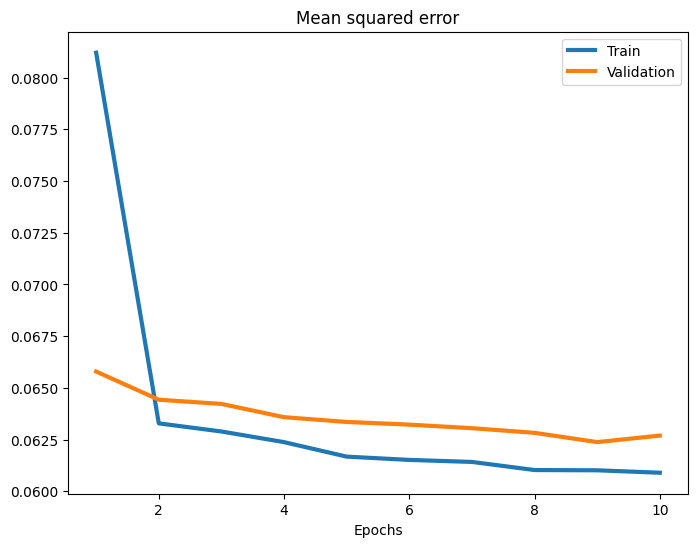

Training MSE = 0.24677520587992938
Validation MSE = 0.25038416968726523


In [18]:
def model_analysis(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.title("Mean squared error")
    sns.lineplot(x=epochs, y=train_loss, label="Train", linewidth=3)
    sns.lineplot(x=epochs, y=val_loss, label="Validation", linewidth=3)
    plt.xlabel("Epochs")

    plt.legend()
    plt.savefig("FirstNet.png", dpi=400)
    plt.show()

    print(f"Training MSE = {np.sqrt(train_loss[-1])}")
    print(f"Validation MSE = {np.sqrt(val_loss[-1])}")

model_analysis(train_loss, val_loss)

Visualize the empirical distribution function of the latent representation obtained from the encoder model.

462/462 [==============================] - 1s 2ms/step


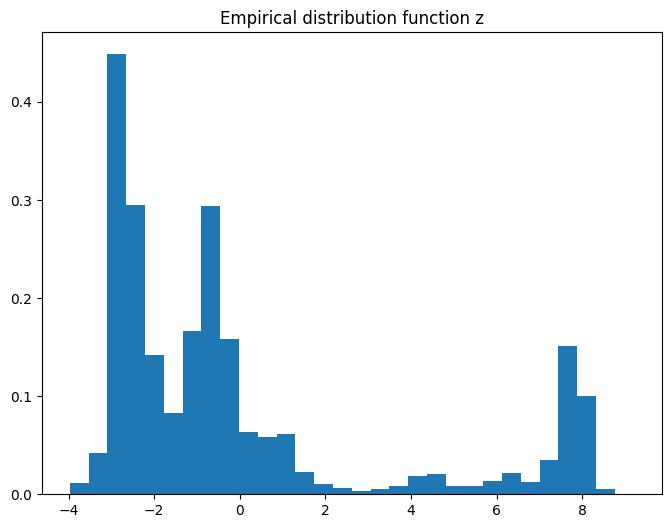

In [19]:
plt.figure(figsize=(8, 6))
plt.title("Empirical distribution function z")
plt.xticks((-8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14))
# use the encoder model to obtain the latent representation (z) of the data input
plt.hist(encoder.predict(transformed_df), bins=30, density=True)
plt.savefig("DistInternal.png", dpi=400)

In [20]:
ae.predict(transformed_df)[0,:]

462/462 [==============================] - 1s 2ms/step


array([ 2.31946304e-01,  5.01819134e-01,  2.63058186e-01,  9.19034034e-02,
        6.13737822e-01, -3.71847302e-03,  2.16360763e-03,  5.62185608e-03,
       -1.26522407e-03,  8.67014378e-03,  1.30034536e-02,  1.11383021e-01,
        1.01078033e-01,  1.06572032e-01,  1.05409987e-01,  1.05283558e-01,
        1.08941838e-01, -9.34148580e-03,  1.60239190e-02, -1.32144392e-02,
       -1.20907351e-02,  1.67152733e-02,  2.75721177e-02,  4.23630551e-02,
        2.02788785e-03,  3.85560915e-02,  4.23160829e-02,  2.88551971e-02,
        3.51205841e-03,  5.73068112e-03,  1.75749138e-02,  1.16068944e-02,
        1.80139244e-02,  9.20460559e-03, -1.00061828e-02,  2.83681080e-02,
        5.18990271e-02,  9.85442847e-03,  1.77904963e-02,  1.69790015e-02,
        1.29046515e-02,  2.11210102e-02,  1.54553261e-02,  1.22674465e-01,
        1.25531659e-01,  3.17531899e-02,  2.06987038e-02,  3.27679794e-03,
        2.59055346e-02,  6.66526146e-03,  1.61047503e-01,  1.72278866e-01,
       -2.26128846e-04,  

Visualize the empirical cumulative distribution function (ECDF) of the first dimension of the latent representation obtained from the encoder model.

462/462 [==============================] - 1s 1ms/step


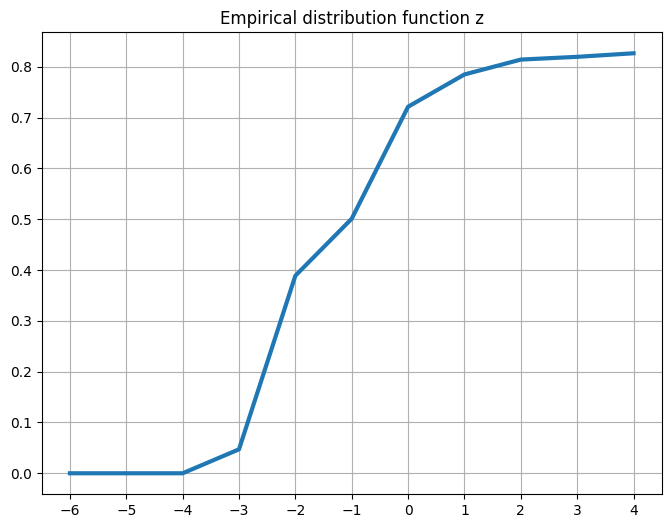

In [21]:
ecdf = ECDF(encoder.predict(transformed_df)[:, 0])
plt.figure(figsize=(8, 6))
plt.title("Empirical distribution function z")
x = (-6,-5, -4, -3, -2, -1, 0, 1, 2, 3, 4)
plt.yticks(np.linspace(0, 1, 11))
plt.xticks(x)
plt.grid()
plt.plot(x, ecdf(x), linewidth=3)
plt.savefig("EmpiricalDF.png", dpi=400)

Visualize the inverted empirical distribution function based on the sample EDF values and their corresponding x-values.

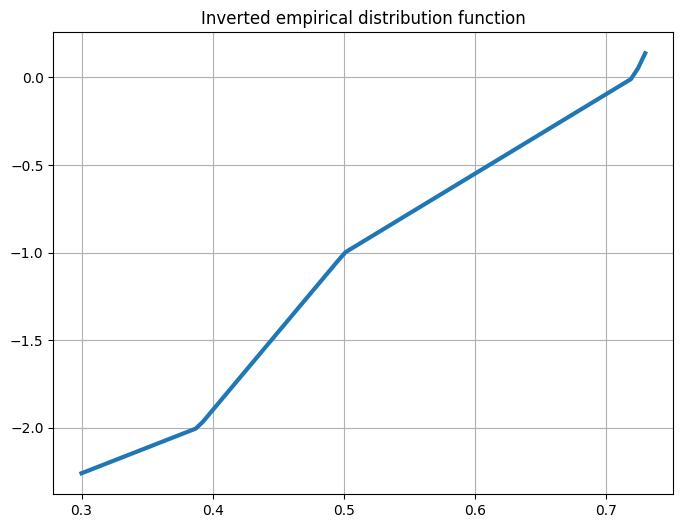

In [22]:
x = (-6,-5, -4, -3, -2, -1, 0, 1, 2, 3, 4)
# calculate the sample EDF values at the specified x-values
sample_edf_values_at_slope_changes = [ecdf(i) for i in x]
inverted_edf = interp1d(sample_edf_values_at_slope_changes, x)

# number of data points to generate
N = 10000
seed(2021)
plt.figure(figsize=(8, 6))
plt.title("Inverted empirical distribution function")
x = np.linspace(0.30, 0.73, 80)
plt.xticks(np.linspace(0, 1.0, 11))
plt.grid()
plt.plot(x, inverted_edf(x), linewidth=3)
plt.savefig("InvertedEmpiricalDF.png", dpi=400)

Generate random values from a specific distribution that resembles the original data distribution using the inverted empirical distribution function.

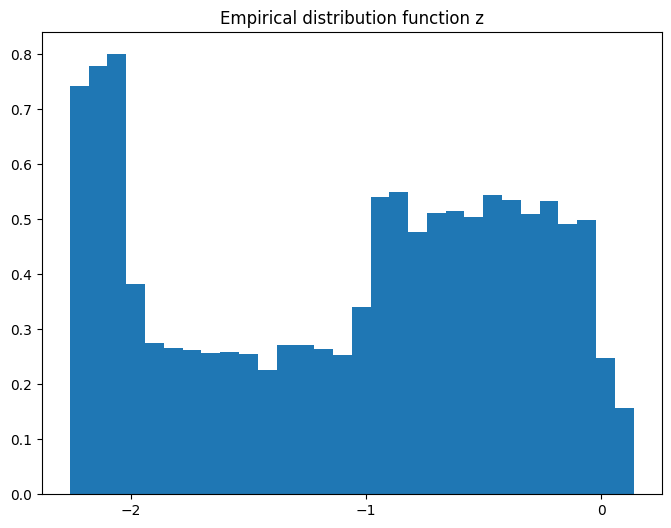

In [23]:
# number of data points to generate
N = 10000
seed(2021)
plt.figure(figsize=(8, 6))
plt.title("Empirical distribution function z")
plt.xticks((-5, -4, -3, -2, -1, 0, 1, 2, 3, 4))
# N random values from a uniform distribution are transformed to follow a specific distribution using the inverted EDF
plt.hist(inverted_edf(uniform(0.30, 0.73, N)), bins=30, density=True)
plt.savefig("DistGenerated.png", dpi=400)

Assess the quality of the autoencoder's reconstruction by calculating the Mean Absolute Error (MAE) between the reconstructed data and the original data.

462/462 [==============================] - 1s 2ms/step


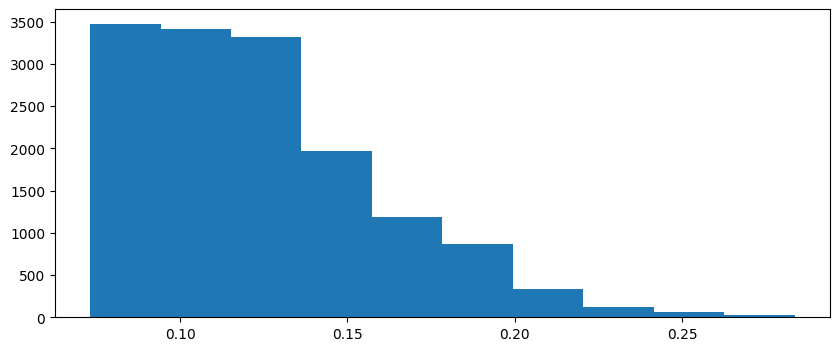

In [24]:
plt.figure(figsize=(10, 4))
# reconstruct the original data
normal_reconstructions = ae.predict(transformed_df)
# compute the Mean Absolute Error between the reconstructed data and the original data
normal_loss = tf.losses.mae(normal_reconstructions, transformed_df)
plt.hist(normal_loss, bins=10)
plt.show()

The threshold value based on the mean and standard deviation of the reconstruction error. This threshold provides a reference point for distinguishing between normal reconstruction errors and potential outliers.

In [25]:
threshold = np.mean(normal_loss) + 2*np.std(normal_loss)
print(threshold)

0.1953453690954322


Visualize the distribution of the reconstruction errors and highlight the threshold for identifying outliers in the reconstruction error.

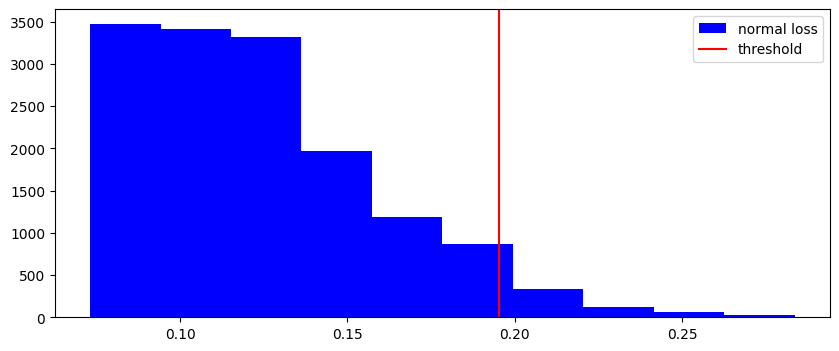

In [26]:
plt.figure(figsize=(10, 4))
plt.hist(normal_loss, bins=10, color='b', label="normal loss")
# add a vertical line to the plot at the position of the threshold value
plt.axvline(threshold, color='r', label="threshold")
plt.legend()
plt.show()

Obtain the indices in descending order of the reconstruction errors.

In [27]:
sorted_indices = np.argsort(normal_loss)[::-1]

Identify and extract a subset of samples from the original dataset that have the 100 highest reconstruction errors and have reconstruction errors exceeding the threshold value.

In [28]:
k = 100  # Number of samples to select
samples_with_high_error = transformed_df.iloc[sorted_indices[:k]]
samples_with_high_error.head()

,weight,stheight,stweight,bmi,bmipct,missing_weight,missing_age,missing_sex,missing_grade,missing_Hispanic_or_Latino,...,indoor_tanning_20 to 39 times,indoor_tanning_3 to 9 times,indoor_tanning_40 or more times,indoor_tanning_nan,difficulty_concentrating_No,difficulty_concentrating_Yes,difficulty_concentrating_nan,qcurrentasthma_nan,qwheresleep_nan,qnbikehelmet_nan
7248,0.353671,0.0,0.0,0.000000,0.0,0,0,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
129,0.046169,0.0,0.0,0.000000,0.0,0,1,0,0,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
100,0.055313,0.0,0.0,0.140038,0.0,0,0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
14232,0.237430,0.0,0.0,0.000000,0.0,0,0,0,1,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
14302,0.132592,0.0,0.0,0.000000,0.0,0,0,0,1,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


In [29]:
# Find indices of tuples with reconstruction values larger than the threshold
anomaly_indices = np.where(normal_loss > threshold)[0]

# Select the corresponding tuples from the original data
anomaly_tuples = transformed_df.iloc[anomaly_indices]

# Print the anomaly tuples
anomaly_tuples.head()


,weight,stheight,stweight,bmi,bmipct,missing_weight,missing_age,missing_sex,missing_grade,missing_Hispanic_or_Latino,...,indoor_tanning_20 to 39 times,indoor_tanning_3 to 9 times,indoor_tanning_40 or more times,indoor_tanning_nan,difficulty_concentrating_No,difficulty_concentrating_Yes,difficulty_concentrating_nan,qcurrentasthma_nan,qwheresleep_nan,qnbikehelmet_nan
3,0.161873,0.0,0.0,0.0,0.0,0,1,1,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
7,0.356232,0.0,0.0,0.0,0.0,0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
12,0.211872,0.0,0.0,0.0,0.0,0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
15,0.043351,0.0,0.0,0.0,0.0,0,1,1,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
16,0.051354,0.0,0.0,0.0,0.0,0,1,1,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0


In [30]:
anomaly_tuples.shape

(649, 746)

Reconstruct the transformed data using the trained autoencoder model and get the combined dataframe of the original transformed data with its reconstructed version.

In [31]:
ae.compile(loss="mean_squared_error", optimizer="adam")

reconstructed_data = ae.predict(transformed_df)

reconstructed_df = pd.DataFrame(reconstructed_data, columns=transformed_df.columns)

columns_to_modify = ["weight","stheight","stweight","bmi","bmipct"]
transformed_df[columns_to_modify] = transformed_df[columns_to_modify].replace(0, np.nan)

combined_df = pd.concat([transformed_df, reconstructed_df], axis=1)
combined_df.head()

462/462 [==============================] - 1s 2ms/step


,weight,stheight,stweight,bmi,bmipct,missing_weight,missing_age,missing_sex,missing_grade,missing_Hispanic_or_Latino,...,indoor_tanning_20 to 39 times,indoor_tanning_3 to 9 times,indoor_tanning_40 or more times,indoor_tanning_nan,difficulty_concentrating_No,difficulty_concentrating_Yes,difficulty_concentrating_nan,qcurrentasthma_nan,qwheresleep_nan,qnbikehelmet_nan
0,0.508875,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.001559,0.009159,0.013678,0.048503,0.650006,0.282720,0.071744,1.036376,1.034335,1.032165
1,0.347927,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.002060,-0.005275,0.012190,0.175206,0.684677,0.132470,0.204280,1.012438,1.008881,1.006712
2,0.142144,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.009524,0.023021,0.026452,0.045178,0.583642,0.328641,0.072114,1.011597,1.010711,1.008594
3,0.161873,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.006294,0.023210,0.033903,0.145065,0.516225,0.318080,0.168589,1.022865,1.016922,1.014122
4,0.415955,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.002023,-0.004202,0.012300,0.165788,0.682099,0.143640,0.194427,1.014218,1.010773,1.008604


Calculate the cost standardization and map reconstructed binary values to categories.

\#1 approach for getting cost values:

In [32]:
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

cost = {}
mapped_categories = {}

for column in transformed_df[categorical_vars]:
  probability = transformed_df[column].mean(axis=0)
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)

  cost[column] = cost_value

for column, cost in cost.items():
    # Map the reconstructed values to categories based on the threshold
    mapped_categories[column] = (reconstructed_df[column] > cost).astype(int)

<ipython-input-32-9a1a964cdb25>:9: RuntimeWarning: divide by zero encountered in double_scalars
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)


Evaluate the performance of the reconstructed categories compared to the original dataset. A higher AUC score indicates better performance in distinguishing different instances.

In [33]:
auc_scores = {}

for column in mapped_categories:

    mapped_values = mapped_categories[column]
    true_labels = transformed_df[column]

    fpr, tpr, _ = roc_curve(true_labels, mapped_values)
    roc_auc = auc(fpr, tpr)

    auc_scores[column] = roc_auc

auc_scores

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/

{'missing_weight': nan,
 'missing_age': 0.5,
 'missing_sex': 0.5,
 'missing_grade': 0.5,
 'missing_Hispanic_or_Latino': 0.5,
 'missing_race': 0.5,
 'missing_stheight': 0.5,
 'missing_stweight': 0.5,
 'missing_bmi': 0.5,
 'missing_bmipct': 0.5,
 'missing_obese': 0.5,
 'missing_overweight': 0.5,
 'missing_sexual_identity': 0.8618233811876981,
 'missing_sex/sexual_contacts': 0.924019429311835,
 'missing_sexid': 0.8814853042780654,
 'missing_sexid2': 0.8759286374862497,
 'missing_sexpart': 0.880215341531738,
 'missing_sexpart2': 0.8807137606332567,
 'missing_seat_belt_use': 0.7337199711463624,
 'missing_riding_with_a_drinking_driver': 0.5,
 'missing_drinking_and_driving': 0.5731935388111494,
 'missing_texting_and_driving': 0.5416804162353703,
 'missing_weapon_carrying': 0.8930454838131716,
 'missing_weapon_carrying_at_school': 0.5,
 'missing_gun_carrying_past_12_mos': 0.5,
 'missing_safety_concerns_at_school': 0.9568239454896991,
 'missing_threatened_at_school': 0.5,
 'missing_physical_fig

In [34]:
merged_df = (pd.DataFrame(mapped_categories)).merge(reconstructed_df[numeric_vars], left_index = True, right_index = True)
merged_df.head(10)

,missing_weight,missing_age,missing_sex,missing_grade,missing_Hispanic_or_Latino,missing_race,missing_stheight,missing_stweight,missing_bmi,missing_bmipct,...,difficulty_concentrating_Yes,difficulty_concentrating_nan,qcurrentasthma_nan,qwheresleep_nan,qnbikehelmet_nan,weight,stheight,stweight,bmi,bmipct
0,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,0.231946,0.501819,0.263058,0.091903,0.613738
1,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,0.235467,0.411295,0.199408,0.082832,0.578844
2,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,0.249652,0.498728,0.269075,0.100222,0.591874
3,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,0.262004,0.478857,0.256471,0.091442,0.559336
4,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,0.235205,0.418025,0.204139,0.083506,0.581438
5,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,0.231293,0.518628,0.274877,0.093588,0.620217
6,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,0.255685,0.493599,0.267050,0.099361,0.585582
7,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,0.232223,0.494702,0.258054,0.091190,0.610994
8,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,0.234935,0.424970,0.209023,0.084202,0.584115
9,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,0.234433,0.437880,0.218100,0.085496,0.589091


\#2 approach for getting cost values:

In [35]:
from matplotlib.offsetbox import TransformedBbox
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

mapped_categories1 = {}

cost_df = pd.DataFrame()

for column in transformed_df[categorical_vars]:
    probability = transformed_df[column].mean(axis=0)
    std = transformed_df[column].std(axis=0)

    cost_values = []

    for index, value in transformed_df[column].items():
        cost_value = (value - probability) / (6.8 * std) if std != 0 else np.inf
        cost_values.append(cost_value)

    cost_df[column] = cost_values

    cost_df.head()

for column, cost in cost_df.items():
    lower_bound = transformed_df[column].mean(axis=0) - cost
    upper_bound = transformed_df[column].mean(axis=0) + cost
    mapped_values = ((reconstructed_df[column] > lower_bound) & (reconstructed_df[column] < upper_bound)).astype(int)
    mapped_categories1[column] = mapped_values

<ipython-input-35-a449625ef75c>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cost_df[column] = cost_values
<ipython-input-35-a449625ef75c>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cost_df[column] = cost_values
<ipython-input-35-a449625ef75c>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy(

In [36]:
auc_scores = {}

for column in mapped_categories1:

    mapped_values = mapped_categories1[column]
    true_labels = transformed_df[column]

    fpr, tpr, _ = roc_curve(true_labels, mapped_values)
    roc_auc = auc(fpr, tpr)

    auc_scores[column] = roc_auc

auc_scores

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/

{'missing_weight': nan,
 'missing_age': 1.0,
 'missing_sex': 1.0,
 'missing_grade': 1.0,
 'missing_Hispanic_or_Latino': 1.0,
 'missing_race': 1.0,
 'missing_stheight': 1.0,
 'missing_stweight': 1.0,
 'missing_bmi': 1.0,
 'missing_bmipct': 1.0,
 'missing_obese': 1.0,
 'missing_overweight': 1.0,
 'missing_sexual_identity': 1.0,
 'missing_sex/sexual_contacts': 0.5608669833729216,
 'missing_sexid': 1.0,
 'missing_sexid2': 1.0,
 'missing_sexpart': 0.5660486674391657,
 'missing_sexpart2': 0.5664831981460023,
 'missing_seat_belt_use': 0.5572466274645451,
 'missing_riding_with_a_drinking_driver': 1.0,
 'missing_drinking_and_driving': 1.0,
 'missing_texting_and_driving': 1.0,
 'missing_weapon_carrying': 0.5728444003964321,
 'missing_weapon_carrying_at_school': 1.0,
 'missing_gun_carrying_past_12_mos': 1.0,
 'missing_safety_concerns_at_school': 0.507710100231303,
 'missing_threatened_at_school': 1.0,
 'missing_physical_fighting': 0.5264032496307238,
 'missing_physical_fighting_at_school': 1.0,
 

In [37]:
merged_df1 = (pd.DataFrame(mapped_categories1)).merge(reconstructed_df[numeric_vars], left_index = True, right_index = True)
merged_df1.head(10)

,missing_weight,missing_age,missing_sex,missing_grade,missing_Hispanic_or_Latino,missing_race,missing_stheight,missing_stweight,missing_bmi,missing_bmipct,...,difficulty_concentrating_Yes,difficulty_concentrating_nan,qcurrentasthma_nan,qwheresleep_nan,qnbikehelmet_nan,weight,stheight,stweight,bmi,bmipct
0,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,0.231946,0.501819,0.263058,0.091903,0.613738
1,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,0.235467,0.411295,0.199408,0.082832,0.578844
2,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,0.249652,0.498728,0.269075,0.100222,0.591874
3,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,0.262004,0.478857,0.256471,0.091442,0.559336
4,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0.235205,0.418025,0.204139,0.083506,0.581438
5,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,0.231293,0.518628,0.274877,0.093588,0.620217
6,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,0.255685,0.493599,0.267050,0.099361,0.585582
7,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,0.232223,0.494702,0.258054,0.091190,0.610994
8,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,0.234935,0.424970,0.209023,0.084202,0.584115
9,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0.234433,0.437880,0.218100,0.085496,0.589091


In [38]:
merged_df1 = merged_df1.merge(transformed_df, left_index = True, right_index = True)

In [39]:
merged_df1.to_csv('yrbss0614_merged.csv', index = False)

from google.colab import files

files.download('yrbss0614_merged.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>